# Research on success rates of video games

## Introduction

The present document is a study on data of video games sales and critic reviews up until 2016, with the main objective of identifying patterns in sales around the world. This information will be used to promote advertising campaigns of 2017 with a better understanding of the current video game sales scenario.

## Data Preprocess

### Introduction

The first step is to explore data and validate information. Our final objective is to delineate patterns between different platforms, genres and consumers.

Data often comes with a few unpredicted issues, and these will be fixed in this preprocessing section. These can include missing values, artifacts and incorrect data types. Analysis is much easier when the data is standardized and categorized. At the end of this section, we expect to have data ready for analysis and the drawing of results.

### Validating Data

#### Objective

In this subsection, we will take a first look at the data and the information available. It's important to make sure that the values are correctly loaded: numeric data should correctly be assigned as integer or float, corresponding to their values.


#### Code

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import scipy.stats as st
from scipy.stats import norm
from scipy.stats.kde import gaussian_kde

path_array = ['games.csv','/games.csv', '/datasets/games.csv', '../datasets/games.csv']

for i in path_array:
    try:
        pd.read_csv(i, nrows=1)
        CSVPATH = i
    except:
        pass

print('Path found is', 'current folder' if CSVPATH == '' else CSVPATH)


Path found is ../datasets/games.csv


In [95]:
games = pd.read_csv(
    CSVPATH
    )

games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [96]:
cat_cols = [col for col in games if games[col].dtype == 'object']
print(f'Cat columns are {cat_cols}')
print('Correcting columns...')
games['User_Score'].replace(to_replace='tbd', value=float('nan'), inplace=True)
games['User_Score'] = pd.to_numeric(games['User_Score'])
cat_cols = [col for col in games if games[col].dtype == 'object']
print(f'Cat columns are now {cat_cols}', '\n')

Cat columns are ['Name', 'Platform', 'Genre', 'User_Score', 'Rating']
Correcting columns...
Cat columns are now ['Name', 'Platform', 'Genre', 'Rating'] 



In [97]:
float_cols = [col for col in games if games[col].dtype == 'float']
print(f'Float columns are {float_cols}')
print('Correcting columns...')
games['Year_of_Release'] = games['Year_of_Release'].astype('Int64')
float_cols = [col for col in games if games[col].dtype == 'float64']
print(f'Float columns are now {float_cols}', '\n')

for col in float_cols:
    games[col] = pd.to_numeric(games[col], downcast='float')

games.info()

Float columns are ['Year_of_Release', 'NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score']
Correcting columns...
Float columns are now ['NA_sales', 'EU_sales', 'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  Int64  
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float32
 5   EU_sales         16715 non-null  float32
 6   JP_sales         16715 non-null  float32
 7   Other_sales      16715 non-null  float32
 8   Critic_Score     8137 non-null   float32
 9   User_Score       7590 non-null   float32
 10  Rating           9949 non-null   object 
dtypes: Int64(1), float32(6), object(4)
memory

#### Results

The data has been loaded and we can check what information are available. For each entry we have:

- Name of the game
- Video game console
- Year of release
- Game genre
- NA sales in USD million
- EU sales in USD million
- JP sales in USD million
- Sales in the rest of the world in USD million
- Critic score
- User score
- Age and content rating


### Missing Values and Artifacts

#### Introduction

After loading the table, we will look for missing values and decide what to do with the empty values. Additionally, we will quickly search for wrong categories of game genres, platforms or content rating, as well as incorrect numeric data.

#### Code

In [98]:
(games.isna().sum()/games.shape[0]*100).sort_values(ascending=False).round(decimals=4)

User_Score         54.5917
Critic_Score       51.3192
Rating             40.4786
Year_of_Release     1.6093
Name                0.0120
Genre               0.0120
Platform            0.0000
NA_sales            0.0000
EU_sales            0.0000
JP_sales            0.0000
Other_sales         0.0000
dtype: float64

In [99]:
display(games[ games['Name'].isna() ].head())
games = games[ games['Name'].notna() ].reset_index(drop=True)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [100]:
print('A few games with missing year of release:')
display(games[games['Year_of_Release'].isna()].head())
print('')
print('Count of missing year of release by genre:')
games[games['Year_of_Release'].isna()]['Genre'].value_counts()

A few games with missing year of release:


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN



Count of missing year of release by genre:


Action          62
Sports          42
Misc            29
Shooter         27
Racing          23
Role-Playing    17
Simulation      16
Fighting        12
Puzzle          11
Platform        10
Adventure       10
Strategy        10
Name: Genre, dtype: int64

In [101]:
def get_year(row):
    name = row['Name'].split()
    for word in name:
        if word.isnumeric():
            return int(word) - 1 if int(word) > 1980 else None
    return None

print('Count of missing values in year of release:', 
    games[games['Year_of_Release'].isna()]['Name'].count()
    )

games.loc[games['Year_of_Release'].isna(), 'Year_of_Release'] = games[games['Year_of_Release'].isna()].apply(get_year, axis=1)

print('Count of missing values in year of release after filling:', 
    games[games['Year_of_Release'].isna()]['Name'].count()
    )

games = games[games['Year_of_Release'].notna()].reset_index(drop=True)

Count of missing values in year of release: 269
Count of missing values in year of release after filling: 254


In [102]:
games['Year_of_Release'] = games['Year_of_Release'].astype('uint16')
(games.isna().sum()/games.shape[0]*100).sort_values(ascending=False).round(decimals=4)

User_Score         54.6023
Critic_Score       51.4308
Rating             40.5918
Name                0.0000
Platform            0.0000
Year_of_Release     0.0000
Genre               0.0000
NA_sales            0.0000
EU_sales            0.0000
JP_sales            0.0000
Other_sales         0.0000
dtype: float64

In [103]:
display(
    (
        games[games['Rating'].isna()].groupby('Genre')['Name'].count()
        /
        games.groupby('Genre')['Name'].count()
    ).sort_values(ascending=False)
)

display(
    (
        games[games['Rating'].isna()].groupby('Platform')['Name'].count().sort_values(ascending=False)
        /
        games.groupby('Platform')['Name'].count().sort_values(ascending=False)
    ).sort_values(ascending=True).head(15)
)

display(
    (
        games.groupby('Genre')['Rating'].value_counts()
    )
)


Genre
Adventure       0.659706
Strategy        0.506686
Misc            0.499128
Fighting        0.484487
Role-Playing    0.480081
Puzzle          0.409490
Platform        0.361048
Sports          0.358222
Action          0.351073
Simulation      0.347725
Racing          0.302685
Shooter         0.231481
Name: Name, dtype: float64

Platform
XB      0.110422
GC      0.156538
X360    0.165316
PC      0.208986
Wii     0.240280
XOne    0.246964
PS3     0.284074
WiiU    0.285714
PS2     0.315370
PS4     0.349490
GBA     0.366215
DS      0.408577
PSP     0.550251
3DS     0.564453
PSV     0.650350
Name: Name, dtype: float64

Genre         Rating
Action        T          670
              M          596
              E10+       468
              E          410
              AO           1
              EC           1
Adventure     E          159
              T          114
              M           98
              E10+        67
              EC           2
Fighting      T          357
              M           48
              E10+        19
              E            8
Misc          E          449
              T          228
              E10+       166
              M           13
              EC           5
              K-A          1
Platform      E          354
              E10+       141
              T           63
              M            3
Puzzle        E          284
              E10+        42
              T           10
Racing        E          577
              T          167
              E10+        95
              M           18
Role-Playing  T          415
              M       

The data does not present enough evidence to correctly fill in missing values of rates, even when grouped by platform or genre. The missing values on rating will be filled as unknown.

In [104]:
games['Rating'].fillna('Unknown', inplace=True)

In [105]:
games.describe().round(decimals=2)

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score
count,16459.00,16459.00,16459.00,16459.00,16459.00,7994.00,7472.00
mean,2006.48,0.26,0.15,0.08,0.05,69.00,7.13
std,5.87,0.82,0.51,0.31,0.19,13.92,1.50
min,1980.00,0.00,0.00,0.00,0.00,13.00,0.00
25%,2003.00,0.00,0.00,0.00,0.00,60.00,6.40
50%,2007.00,0.08,0.02,0.00,0.01,71.00,7.50
75%,2010.00,0.24,0.11,0.04,0.03,79.00,8.20
max,2016.00,41.36,28.96,10.22,10.57,98.00,9.70


In [106]:
real_games = games

critic_pivot = games.query('Critic_Score.notna()').pivot_table(index='Platform', columns='Genre', values='Critic_Score')

def fill_critic(row):
    if row['Platform'] in critic_pivot.index.values:
        return critic_pivot.loc[row['Platform'], row['Genre']]
    else:
        return None

games.loc[ games['Critic_Score'].isna() , 'Critic_Score'] = (
    games.query('Critic_Score.isna()')
                .apply(fill_critic, axis=1)
               )

user_pivot = games.query('User_Score.notna()').pivot_table(index='Platform', columns='Genre', values='User_Score')

def fill_user(row):
    if row['Platform'] in user_pivot.index.values:
        return user_pivot.loc[row['Platform'], row['Genre']]
    else:
        return None
    
games.loc[ games['User_Score'].isna(), 'User_Score'] = (
    games.query('User_Score.isna()')
                .apply(fill_user, axis=1)
)

(games.isna().sum()/games.shape[0]*100).sort_values(ascending=False).round(decimals=4)

Critic_Score       6.7501
User_Score         6.7076
Name               0.0000
Platform           0.0000
Year_of_Release    0.0000
Genre              0.0000
NA_sales           0.0000
EU_sales           0.0000
JP_sales           0.0000
Other_sales        0.0000
Rating             0.0000
dtype: float64

In [107]:
games['Critic_Score'].fillna(games['Critic_Score'].mean(), inplace=True)
games['User_Score'].fillna(games['User_Score'].mean(), inplace=True)

(games.isna().sum()/games.shape[0]*100).sort_values(ascending=False).round(decimals=4)

Name               0.0
Platform           0.0
Year_of_Release    0.0
Genre              0.0
NA_sales           0.0
EU_sales           0.0
JP_sales           0.0
Other_sales        0.0
Critic_Score       0.0
User_Score         0.0
Rating             0.0
dtype: float64

In [108]:
print(f'Number of duplicated rows:', games[games.duplicated()].count().sum())

Number of duplicated rows: 0


In [109]:
games[cat_cols].describe()

,Name,Platform,Genre,Rating
count,16459,16459,16459,16459
unique,11432,31,12,9
top,Need for Speed: Most Wanted,PS2,Action,Unknown
freq,12,2134,3307,6681


In [110]:
print('Unique platforms:', games['Platform'].unique(), '\n')
print('Unique genres:', games['Genre'].unique(), '\n')
print('Unique ratings:', games['Rating'].unique(), '\n')


Unique platforms: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX'] 

Unique genres: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy'] 

Unique ratings: ['E' 'Unknown' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP'] 



In [111]:
sales_cols = ['NA_sales', 'EU_sales', 'JP_sales', 'Other_sales']
games['Total_sales'] = games[sales_cols].sum(axis=1)
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16459 entries, 0 to 16458
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16459 non-null  object 
 1   Platform         16459 non-null  object 
 2   Year_of_Release  16459 non-null  uint16 
 3   Genre            16459 non-null  object 
 4   NA_sales         16459 non-null  float32
 5   EU_sales         16459 non-null  float32
 6   JP_sales         16459 non-null  float32
 7   Other_sales      16459 non-null  float32
 8   Critic_Score     16459 non-null  float32
 9   User_Score       16459 non-null  float32
 10  Rating           16459 non-null  object 
 11  Total_sales      16459 non-null  float32
dtypes: float32(7), object(4), uint16(1)
memory usage: 996.7+ KB


#### Results

We found missing values in Genre, Name, Year of Release, Ratings and Scores, in ascending order of percentages. On the columns Genre and Name, only two entries had values missing for these columns, so these were deleted right away. The same has been done to entries with Year of Release column missing, as these comprised only 1.24% of total data. For missing ratings, we added the category 'Unknown'.

As critic and user scores, these columns have more than 50% as missing values. Fortunately, that information is not vital for our research, as sales are the dependent variables of interest. Anyhow the strategy for filling in empty values was using the means considering platform and genre. Any values still left empty - because there weren't other games with the same platform and genre - were filled in with the mean of the whole columns independently on platform and genre. The means were used because the population does not present majority of significant outliers.

The missing values could be related to information just not being available at the websites, as less known games do not get many User and Critic reviews. For the empty values in year of release, it seems like a technical failure.

In the big picture, no big issues were found regarding incorrect data. However, there could still be artifacts when grouping data by categories. If there are any, they will be filtered out during data analysis. We added a column called Total sales to better visualize global sales for each game.

### Conclusion

The preprocessing stage of the research concludes with loaded data of games ready to be analyzed, including optimized data types, filled in values and validation of outliers. The main issues found were regarding missing values. Rows with important data missing had low percentages, so these rows were deleted right away. Empty values for scores required a categorized strategy, and were mostly filled with mean values by platform and genre.

## Data Analysis

### Introduction

In this section, we ain to draw conclusions from the data. Some of these conclusions include identifying what part of the data should we focus our attention to - what years and platforms should we focus our attention to? - or come to findings about the most promising platforms and genres of games. Furthermore, we will take a look at how scores affect sales and check patterns regarding regions of sales.


### Filtering the Data

#### Objective

Our data has information since 1980, and not all of the platforms are relevant for our research. We will look at lifespans of video game platforms and decide which are the most relevant platforms for 2017. To do that, we will check the average lifespan and analyze data starting from the average lifespan in years ago.

#### Code

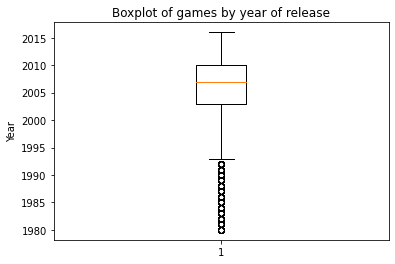

In [112]:
plt.boxplot(games['Year_of_Release'])
plt.title('Boxplot of games by year of release')
plt.ylabel('Year')
plt.show()

In the graph above, we can see that there were few games produced before 1995. They can be regarded as outliers in our data, so we can filter them out right away. Our data is probably more consistent after 1995. We should first take a look at the lifespan of videogames to decide on what part of the data we will focus on.

In [113]:
backup_games = games
games = games.query('Year_of_Release > 1995')
highest_sales_platforms = games.pivot_table(index='Platform', values='Total_sales', aggfunc='sum').sort_values(by='Total_sales', ascending=False).head(10).index.values

games = games[ games['Platform'].isin(highest_sales_platforms) ]
print('Top 10 platforms with highest sales:', highest_sales_platforms)

Top 10 platforms with highest sales: ['PS2' 'X360' 'PS3' 'Wii' 'DS' 'PS' 'PS4' 'GBA' 'PSP' '3DS']


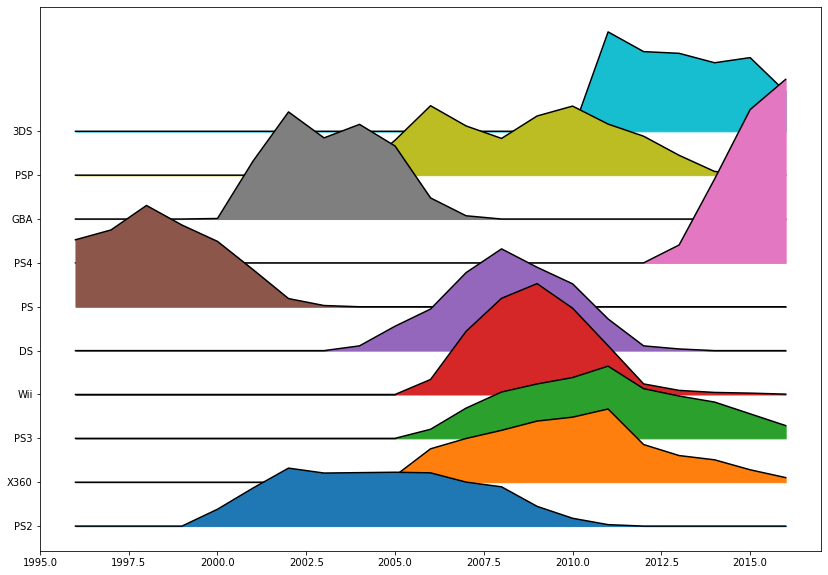

In [114]:
bins = range(1996, 2017)
platform_lifespan = {}
distribution_data = []
for col in highest_sales_platforms:
    selected = games.query('Platform == @col')['Year_of_Release']
    lifespan = selected.max() - selected.min()
    platform_lifespan[col] = lifespan
    selected = games.query('Platform == @col').groupby('Year_of_Release')['Name'].count()
    distribution_data.append(selected)
    
platform_lifespan = pd.Series(platform_lifespan, name='Lifespan')

plot_data = pd.DataFrame(index=highest_sales_platforms, data=distribution_data).fillna(0)
distribution_data = np.array(plot_data)
years_data = plot_data.columns

n_points = 21
xx = np.linspace(np.min(years_data),
                 np.max(years_data), n_points)
colors = ['y', 'b', '']
ys = []
plt.figure(figsize=(14, 10))
for i, d in enumerate(distribution_data):
    d = d/(sum(d))
    y = i*(1.0-0.9)
    ys.append(y)
    plt.fill_between(xx, np.ones(n_points)*y, 
                         d+y, zorder=len(distribution_data)-i+1, color='C'+str(i))
    plt.plot(xx, d+y, c='k', zorder=len(distribution_data)-i+1)
plt.yticks(ys, highest_sales_platforms)
plt.show()

The graph above shows the progression of games produced by year for the top 10 best selling platforms. We can check when games started being produced for each platform to better understand the lifespan of each platform.

In [115]:
display(platform_lifespan.sort_values(ascending=False))
print('Mean', platform_lifespan.mean())
print('Median', platform_lifespan.median())

PS2     11
X360    11
PSP     11
PS3     10
Wii     10
DS       9
PS       7
GBA      7
3DS      5
PS4      3
Name: Lifespan, dtype: int64

Mean 8.4
Median 9.5


In [116]:
games = backup_games.query('Year_of_Release >= 2014')
highest_sales_platforms = games.pivot_table(index='Platform', values='Total_sales', aggfunc='sum').sort_values(by='Total_sales', ascending=False).index.values

games = games[ games['Platform'].isin(highest_sales_platforms) ].reset_index(drop=True)
print('Platforms with sales after 2014:', highest_sales_platforms)

Platforms with sales after 2014: ['PS4' 'XOne' '3DS' 'PS3' 'X360' 'WiiU' 'PC' 'PSV' 'Wii' 'PSP']


#### Results

The average lifespan of video game platforms is 11 years - that's how long games keep being produced for the same console. Apparently, by 2016 many consoles are ending their lifespans, and we risk considering old platforms if we choose data starting from too much time ago. Considering the last completed year was 2015, we decided to include only data after the last console has died out. Therefore, we have chosen data starting from the year 2014. By plotting the distribution of games produced by year, we could also understand the behavior of games production - it generally follows a normal distribution.

Platforms included are: 'PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU', 'PC', 'PSV', 'Wii' and 'PSP'.

### Analyzing Sales

#### Objective

Now that the main platforms to be analyzed have been chosen, we can start looking at the most promising ones. Those will clearly be the ones with an expanding market. We can check the growth of sales along time by the release year of games.

#### Code

In [117]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

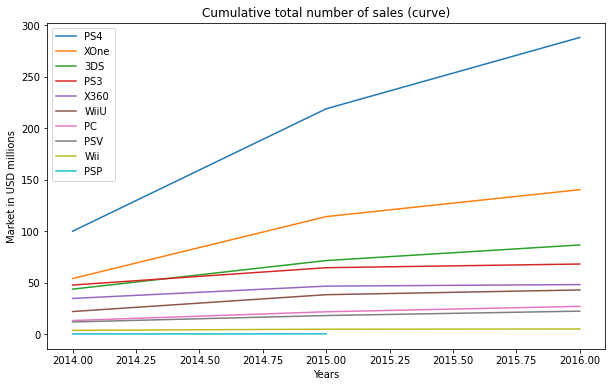

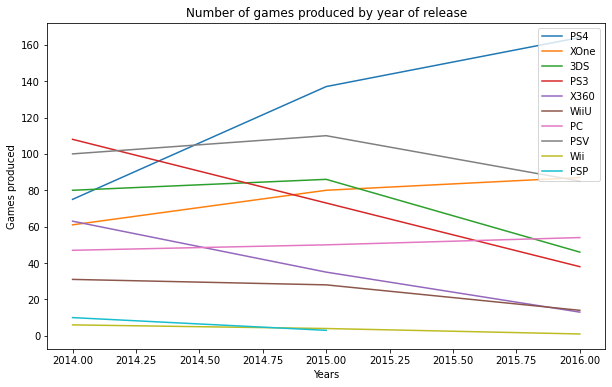

In [118]:
bins = range(2003, 2017)

distribution_data = []
sales_data = []

for col in highest_sales_platforms:
    selected = games.query('Platform == @col').groupby('Year_of_Release')['Name'].count()
    distribution_data.append(selected)
    selected = games.query('Platform == @col').groupby('Year_of_Release')['Total_sales'].sum()
    sales_data.append(selected)

plt.figure(figsize=(10, 6))

for chart, k in zip(sales_data, range(len(sales_data))):
    for i in range(1, len(chart.values)):
        chart.values[i] = chart.values[i] + chart.values[i-1]
    plt.plot(chart.index, chart.values, label=highest_sales_platforms[k])
plt.legend(loc='upper left')
plt.title('Cumulative total number of sales (curve)')
plt.ylabel('Market in USD millions')
plt.xlabel('Years')
plt.show()

plt.figure(figsize=(10, 6))

for chart, k in zip(distribution_data, range(len(distribution_data))):
    plt.plot(chart.index, chart.values, label=highest_sales_platforms[k])
plt.legend(loc='upper right')
plt.title('Number of games produced by year of release')
plt.ylabel('Games produced')
plt.xlabel('Years')
plt.show()

Both of these graphs show very relevant information about the current state of video game platforms. By looking at the first one, we can see the total revenue for platforms. We should look for platforms with a rising graph: the ones with a stapled graph mean not many games are still being produced and the market is currently shrinking. After that, we can look at platforms with games still on production on the second graph, as a second index to look for promising platforms.

The most profitable platforms currently are in order PS4, XOne and PC, in order of total revenue, with 3DS coming in as an honorable mention. Platforms XOne and PS4 have a big market on the rising. PC has a steady market with low but rising revenuem, with continuous production of games. 3DS has a big market, but less and less games are being produced, which means it already started to shrink.  Other platforms show stapled markets with lesser games being produced as times passes, meaning their market is shrinking.

Number of successful games (total sales > 1) by platform:


PS4     69
XOne    43
3DS     16
PS3     13
X360    13
WiiU    11
PC       4
PSV      1
Wii      1
PSP      0
dtype: int64

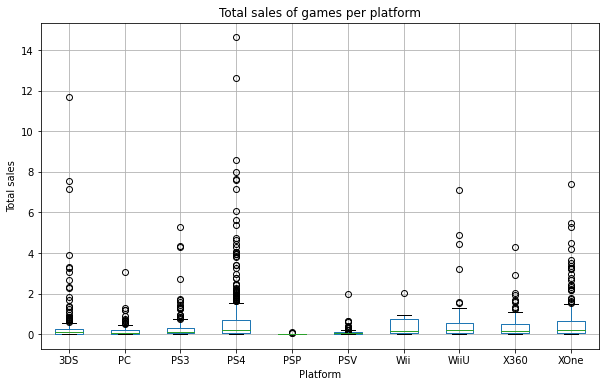

In [119]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

platform_sales = games.pivot(columns='Platform', values='Total_sales')

plt.figure(figsize=(10,6))
platform_sales.boxplot()


n_successful_games = {}
for col in platform_sales:
    n_successful_games[col] = platform_sales[platform_sales[col] > 1][col].count()

print('Number of successful games (total sales > 1) by platform:')
display(pd.Series(n_successful_games).sort_values(ascending=False))

plt.title('Total sales of games per platform')
plt.xlabel('Platform')
plt.ylabel('Total sales')
plt.show()



This graph shows the points of revenue per platform. We can see that most games show a relatively low revenue, and that's a pattern across all platforms. Platforms with highest average revenue are XOne as PS4, although there are very successful games in 3DS and WiiU platforms. After those, we can still see some relevance by last generation consoles such as X360 and PS3.

#### Results

In this subsection we defined the promising platforms that our campaign should look forward to. This decision has been done considering expanding and shrinking markets and total revenue. The most promising platforms are PS4, XOne, PC and 3DS 
### Analyzing Scores

#### Objective

User and critic scores are expected to have a considerable impact over sales. We will check that by verifying the correlation coefficients between sales and scores for the PS4.

#### Code

In [120]:
print('Highest count of user score by platform:')
display(games.query('User_Score.notna()').groupby('Platform')['Name'].count().sort_values(ascending=False).head())

print('Highest count of critic score by platform:')
games.query('Critic_Score.notna()').groupby('Platform')['Name'].count().sort_values(ascending=False).head()

Highest count of user score by platform:


Platform
PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
Name: Name, dtype: int64

Highest count of critic score by platform:


Platform
PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
Name: Name, dtype: int64

,User_Score,Critic_Score,Total_sales
User_Score,1.000000,0.532616,-0.056701
Critic_Score,0.532616,1.000000,0.335604
Total_sales,-0.056701,0.335604,1.000000


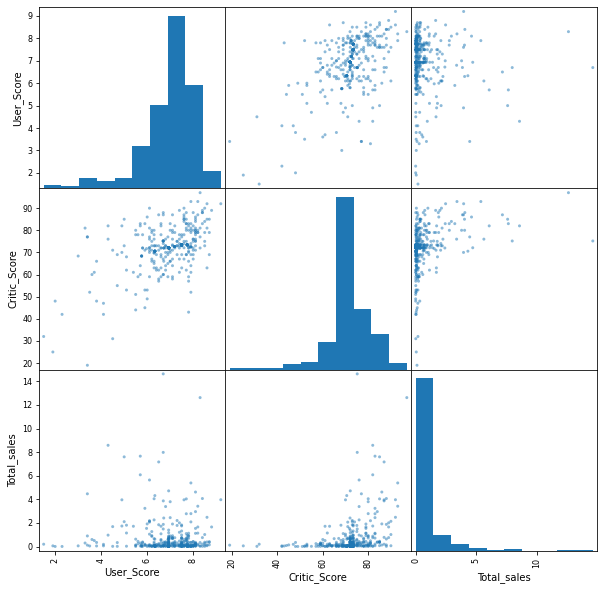

In [121]:
ps4 = games.query('Platform == "PS4"')[['Name', 'User_Score', 'Critic_Score', 'Total_sales']]

display(ps4.corr())
pd.plotting.scatter_matrix(ps4, figsize=(10,10))
plt.show()

This scatter matrix cross values of sales and scores for the PS4. We can confirm that most sales stay at low revenues, and that total sales do increase with higher critic scores. However, user scores are not so relevant to total sales, showing little to no correlation at all. It is interesting to point out that critic score only guarantee a success for really high critic scores, and that average reviews only raises the chances of a commercial success by a margin.

In [122]:
(
    games[games['Name'].isin(ps4['Name'])].groupby('Platform')['Total_sales'].mean().sort_values(ascending=False)
    -
    games.groupby('Platform')['Total_sales'].mean().sort_values(ascending=False)
).sort_values(ascending=False)


Platform
Wii     0.339091
PS3     0.101029
X360    0.092822
PSV     0.065335
PSP     0.022308
PC      0.009387
PS4     0.000000
XOne   -0.047614
3DS    -0.154868
WiiU   -0.291730
Name: Total_sales, dtype: float32

In [123]:
genre_compare = games.pivot_table(index='Genre', values=['Total_sales', 'User_Score', 'Critic_Score'])
genre_compare.sort_values('Total_sales', ascending=False)

,Critic_Score,Total_sales,User_Score
Genre,,,
Shooter,74.500824,1.335469,6.566592
Sports,70.743111,0.680000,5.413676
Platform,74.734451,0.476053,6.793334
Fighting,71.041481,0.470333,7.045111
Role-Playing,73.400963,0.459005,7.475033
Racing,71.828819,0.398841,6.402706
Misc,71.932205,0.332301,6.972109
Action,68.965034,0.322068,6.833713
Simulation,69.460121,0.298409,6.735536


The genre with the highest sale rates is shooter games by a large margin. However, they aren't the best reviewed by both critics and users accross genres. Those are role-playing and adventure games. The table above shows relevant information to define how acclaimed are games of each genre on average.

#### Results

Reviews have proven themselves important for sales only for high revenue games. The correlation of critic scores with total sales is higher than that of user scores, which is practically non-existent. Good critic reviews raise the chances of commercial successes by a large margin, but they only show really high sales for grades above 90.

### Analyzing Regions

#### Objective

At this point, we will have a look at the difference between sales accross regions. The preferred games and best sellers can vary quite a lot. What are the patterns for preferences in each continent?

#### Code

In [124]:
region_genre = games.pivot_table(index='Genre', values=['JP_sales', 'EU_sales', 'NA_sales'])
print('Preferred genres in JP:')
display(region_genre['JP_sales'].sort_values(ascending=False).head()/region_genre['JP_sales'].sum())
print('Preferred genres in NA:')
display(region_genre['NA_sales'].sort_values(ascending=False).head()/region_genre['NA_sales'].sum())
print('Preferred genres in EU:')
display(region_genre['EU_sales'].sort_values(ascending=False).head()/region_genre['EU_sales'].sum())

Preferred genres in JP:


Genre
Role-Playing    0.212582
Fighting        0.160070
Platform        0.106731
Puzzle          0.100156
Simulation      0.079156
Name: JP_sales, dtype: float32

Preferred genres in NA:


Genre
Shooter         0.311575
Sports          0.144608
Fighting        0.104558
Platform        0.090182
Role-Playing    0.076436
Name: NA_sales, dtype: float32

Preferred genres in EU:


Genre
Shooter       0.263911
Sports        0.146443
Racing        0.105581
Platform      0.092261
Simulation    0.085539
Name: EU_sales, dtype: float32

In [125]:
region_platform = games.pivot_table(index='Platform', values=['JP_sales', 'EU_sales', 'NA_sales'])
print('Preferred platforms in JP:')
display(region_platform['JP_sales'].sort_values(ascending=False).head()/region_platform['JP_sales'].sum())
print('Preferred platforms in NA:')
display(region_platform['NA_sales'].sort_values(ascending=False).head()/region_platform['NA_sales'].sum())
print('Preferred platforms in EU:')
display(region_platform['EU_sales'].sort_values(ascending=False).head()/region_platform['EU_sales'].sum())

Preferred platforms in JP:


Platform
3DS     0.435565
WiiU    0.209010
PS3     0.106936
PSV     0.102876
PS4     0.083379
Name: JP_sales, dtype: float32

Preferred platforms in NA:


Platform
XOne    0.223919
WiiU    0.166601
PS4     0.164751
X360    0.160162
Wii     0.118786
Name: NA_sales, dtype: float32

Preferred platforms in EU:


Platform
PS4     0.242282
Wii     0.164945
XOne    0.142105
WiiU    0.126193
X360    0.097760
Name: EU_sales, dtype: float32

In [126]:
region_rating = games.pivot_table(index='Rating', values=['JP_sales', 'EU_sales', 'NA_sales'])
print('Preferred ratings in JP:')
display(region_rating['JP_sales'].sort_values(ascending=False).head()/region_rating['JP_sales'].sum())
print('Preferred ratings in NA:')
display(region_rating['NA_sales'].sort_values(ascending=False).head()/region_rating['NA_sales'].sum())
print('Preferred ratings in EU:')
display(region_rating['EU_sales'].sort_values(ascending=False).head()/region_rating['EU_sales'].sum())

Preferred ratings in JP:


Rating
Unknown    0.336643
T          0.241682
E          0.180898
M          0.133945
E10+       0.106832
Name: JP_sales, dtype: float32

Preferred ratings in NA:


Rating
M          0.361932
E          0.230469
E10+       0.178675
T          0.142970
Unknown    0.085953
Name: NA_sales, dtype: float32

Preferred ratings in EU:


Rating
M          0.365943
E          0.275144
E10+       0.146755
T          0.130476
Unknown    0.081682
Name: EU_sales, dtype: float32

#### Results

The patterns for continents are very different. Japan generally prefers role-playing games and mobile platforms, while shooter and sports games are the most common in North America and Europe. It is also worth noting that Japan has higher sales for mobile platforms such as the 3DS, while North America and Europe show higher sales for series like the Playstation or the Xbox. Additionally, Japan users tend more to games teen ratings, meanwhile North America and Europe have mature games as the best sellers.


### Conclusion

The analysis and tables presented during the code sessions show valuable information about the analyzed data. They include the definition of the most promising platforms, which are the latest releases in the Xbox and Playstation series. However, by looking at the data considering regions and sales, Japan has very different preference patterns for users. These differences may be cultural, as well as related to gaming companies. Japan is a big producer of video games, and companies like Nintendo, which produces games mainly for Everyone or Teens, are headquartered in Japan. This should definitely be taken into account when planning the campaign: the region.

## Hypothesis testing

### Introduction

By making use of statistical methods, we can test hypothesis of patterns in our data and get some additional conclusions about means for genres and platforms. We will test user scores in different platforms and genres to see if there are any relations between then. The statistical tests are made by assuming a hypothesis and then checking wether there is enough evidence to reject it, or there isn't enough evidence and it is a possible hypothesis. We will test two hypotheses:

When comparing probabilities, we will use a probability reference value of 1% to tell whether a statement can be rejected or not, because so much information has been filled in for our data, and data is not very reliable.

### User Scores in DIfferent Platforms

#### Objective

Question 1: Are Xbox One and PC average user scores are generally the same? 
- *The null hypothesis:* Games have the same average user score in Xbox One and PC. 
- *The alternative hypothesis:* Games do not have the same average user score in Xbox One and PC. 

Since some games are made for both Xbox One and PC, we decided to use these games as main reference for this study, counting up to 80 games, but allowing us to make a paired sample analysis.

#### Code

In [127]:
alpha = 0.01

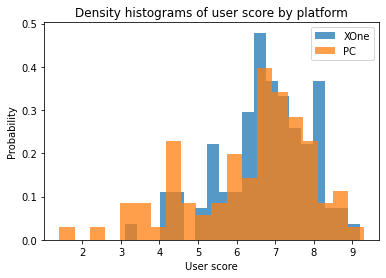

In [128]:
xone_and_pc = games.query('Platform in ["XOne", "PC"]').reset_index(drop=True)
test_xone_and_pc = xone_and_pc.pivot_table(index='Name', values='User_Score', columns='Platform').dropna()
plt.hist(test_xone_and_pc['XOne'], density=True, alpha=0.75, bins=20)
plt.hist(test_xone_and_pc['PC'], density=True, alpha=0.75, bins=20)
plt.legend(['XOne', 'PC'])
plt.title('Density histograms of user score by platform')
plt.ylabel('Probability')
plt.xlabel('User score')
plt.show()

The histograms show a higher left skew for PC user scores, while the Xbox One user scores are more centered around the peak.

In [129]:
print('Testing user scores of XOne and PC...')

array1 = test_xone_and_pc[test_xone_and_pc['XOne'].notna()]['XOne'].values
array2 = test_xone_and_pc[test_xone_and_pc['PC'].notna()]['PC'].values
result = st.ttest_rel(array1, array2)


# array1 = games.query('Platform == "XOne"')['User_Score'].values
# array2 = games.query('Platform == "PC"')['User_Score'].values
# result = st.ttest_ind(array1, array2)


print(f"P-value: {result.pvalue}")
print(f"Probability: {result.pvalue:.2%}")
if result.pvalue > alpha:
    print(f"It is too high, so both sets are likely to have come from the same population (null hypothesis can't be rejected).")
else:
    print(f"It is too low, so we have evidence that both sets are not from the the same population (null hypothesis rejected).")

Testing user scores of XOne and PC...
P-value: 0.00041391401346785463
Probability: 0.04%
It is too low, so we have evidence that both sets are not from the the same population (null hypothesis rejected).


#### Results

By using a significance threshold of 1%, the null hypothesis has been rejected. That means we have evidence to believe average user scores are different for different platforms. The data used was that of 80 games produced in both Xbox One and PC, but the test shows the same results with or without using all of the sampled data.

### User Score in Different Genres

#### Objective

Question 2: Are action and sports games average user scores different?
- *The null hypothesis:* Action and sports games have the same average user scores.
- *The alternative hypothesis:* Action and sports games do not have the same average user scores.

#### Code

Genre,Action,Sports
count,619.00,161.00
mean,6.83,5.41
std,0.97,1.69
min,2.00,0.20
25%,6.56,4.30
50%,6.93,5.78
75%,7.18,6.51
max,9.00,8.80


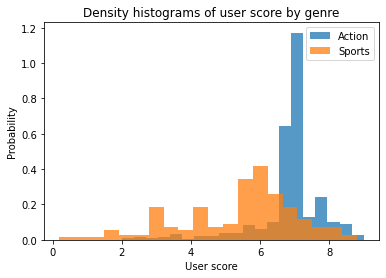

In [92]:
action_and_sports = games.query('Genre in ["Action", "Sports"]').reset_index(drop=True)
test_action_and_sports = action_and_sports.pivot_table(index=action_and_sports.index, values='User_Score', columns='Genre')

display(test_action_and_sports.describe().round(decimals=2))

plt.hist(test_action_and_sports['Action'], density=True, alpha=0.75, bins=20)
plt.hist(test_action_and_sports['Sports'], density=True, alpha=0.75, bins=20)
plt.legend(['Action', 'Sports'])
plt.title('Density histograms of user score by genre')
plt.ylabel('Probability')
plt.xlabel('User score')
plt.show()


Although the graphs overlap quite a bit, the data for sports is skewed to the left, showing that sport games have quite a few badly reviewed games.

In [93]:
print('Testing user scores of Action and Sports...')
array1 = test_action_and_sports[test_action_and_sports['Action'].notna()]['Action'].values
array2 = test_action_and_sports[test_action_and_sports['Sports'].notna()]['Sports'].values
result = st.ttest_ind(array1, array2)

print(f"P-value: {result.pvalue}")
print(f"Probability: {result.pvalue:.2%}")
if result.pvalue > alpha:
    print(f"It is too high, so both sets are likely to have come from the same population (null hypothesis can't be rejected).")
else:
    print(f"It is too low, so we have evidence that both sets are not from the the same population (null hypothesis rejected).")

Testing user scores of Action and Sports...
P-value: 2.6933084611234397e-39
Probability: 0.00%
It is too low, so we have evidence that both sets are not from the the same population (null hypothesis rejected).


#### Results 

Although the histograms seemed similar, the statistical significance of user scores in samples of action games and sports games is very low. We have evidence to reject the null hypothesis and believe that average user scores for these two genres are different.

## Overall Conclusion

Our objective in this research was to outline patterns in sales of games to assist an advertising campaign, as well as draw tendencies in the gaming industry such as promising platforms and genres, by region.

We got details about more than 15000 games dating back to the first games released for video games. It contained issues in review scores which were dealt with and haven't impacted the research largely. After preprocessing the data, we did the exploratory data analysis, plotted density histograms and total sales along time, and came to the following conclusions about the data in this sample: 

- Lifespan of video game platforms revolves around 11 years.
- Most promising platforms are PS4, XOne, PC and 3DS. The first two will rise in the next few years.
- 3DS is the preferred platforms in Japan, but it has had a rough release with shrinking number of games produced.
- The Wii is taking very long to die out, and still holds a big share of the market in the united states.
- Reviews do not make a success hit for a game, but Critic scores are correlated with sales, specially for high grades.
- NA and EU have a more mature gaming audience than in Japan.
- Average means accross platforms and genres are generally different. This resul has been statistically tested.

In conclusion, we believe the information developed in this research provide very useful insights about what to look forward to in the next year. Looking at the region of the next campaign and what video game consoles are trending is of utmost importance. Furthermore, critic scores are an important part of keeping high sales, while user scores are much less looked at.